# Проект для ТелеДом

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Моя задача — обучить на этих данных модель для прогноза оттока клиентов. В изначальных данных нет как таковой целевой переменной, по этому я добавлю новый признак а именно то окончился договор или нет и эта переменная будет целевой.

In [1]:
!pip install catboost -q

In [2]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install ydata-profiling -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-learn optuna -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.linear_model import LogisticRegression
import logging
import warnings
from sklearn.exceptions import ConvergenceWarning
import os
from phik import resources
from phik.report import plot_correlation_matrix
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

## Загрузка данных
загрузим данные

In [6]:
path_1 = r'C:\Users\INVALID\Downloads\contract_new.csv'
path_2 = r'/datasets/contract_new.csv'

try:
    if os.path.exists(path_1):
        data_contract = pd.read_csv(path_1)
        print(f"Файл найден по пути {path_1}")
    elif os.path.exists(path_2):
        data_contract = pd.read_csv(path_2)
        print(f"Файл найден по пути {path_2}")
    else:
        raise FileNotFoundError("Файл не найден по указанным путям.")
except Exception as e:
    print(f"Произошла ошибка: {e}")

Файл найден по пути C:\Users\INVALID\Downloads\contract_new.csv


In [7]:
data_contract

customerID   BeginDate EndDate            Type PaperlessBilling  \
0     7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1     5575-GNVDE  2017-04-01      No        One year               No   
2     3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3     7795-CFOCW  2016-05-01      No        One year               No   
4     9237-HQITU  2019-09-01      No  Month-to-month              Yes   
...          ...         ...     ...             ...              ...   
7038  6840-RESVB  2018-02-01      No        One year              Yes   
7039  2234-XADUH  2014-02-01      No        One year              Yes   
7040  4801-JZAZL  2019-03-01      No  Month-to-month              Yes   
7041  8361-LTMKD  2019-07-01      No  Month-to-month              Yes   
7042  3186-AJIEK  2014-08-01      No        Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  
0              Electronic check           29.85        31.04  
1                  Mailed check           56.95      2071.84  
2                  Mailed check           53.85       226.17  
3     Bank transfer (automatic)           42.30       1960.6  
4              Electronic check           70.70        353.5  
...                         ...             ...          ...  
7038               Mailed check           84.80       2035.2  
7039    Credit card (automatic)          103.20       7430.4  
7040           Electronic check           29.60        325.6  
7041               Mailed check           74.40        520.8  
7042  Bank transfer (automatic)          105.65      7251.82  

[7043 rows x 8 columns]

Сразу изменим типы данных на корректные

In [8]:
data_contract['TotalCharges'] = pd.to_numeric(data_contract['TotalCharges'], errors='coerce')

data_contract['BeginDate'] = pd.to_datetime(data_contract['BeginDate'], errors='coerce')

data_contract['EndDate'] = data_contract['EndDate'].replace('No', pd.NaT)

data_contract['EndDate'] = pd.to_datetime(data_contract['EndDate'], errors='coerce')

print(data_contract['PaperlessBilling'].dtypes)
print(data_contract['TotalCharges'].dtypes)
print(data_contract['BeginDate'].dtypes)
print(data_contract['EndDate'].dtypes)

object
float64
datetime64[ns]
datetime64[ns]


Типы данных заменены, признак добавлен.

In [9]:
path_11 = r'C:\Users\INVALID\Downloads\personal_new.csv'
path_22 = r'/datasets/personal_new.csv'

try:
    if os.path.exists(path_11):
        personal_phone = pd.read_csv(path_11)
        print(f"Файл найден по пути {path_11}")
    elif os.path.exists(path_2):
        personal_phone = pd.read_csv(path_22)
        print(f"Файл найден по пути {path_22}")
    else:
        raise FileNotFoundError("Файл не найден по указанным путям.")
except Exception as e:
    print(f"Произошла ошибка: {e}")
personal_phone.info()

Файл найден по пути C:\Users\INVALID\Downloads\personal_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
personal_phone

customerID  gender  SeniorCitizen Partner Dependents
0     7590-VHVEG  Female              0     Yes         No
1     5575-GNVDE    Male              0      No         No
2     3668-QPYBK    Male              0      No         No
3     7795-CFOCW    Male              0      No         No
4     9237-HQITU  Female              0      No         No
...          ...     ...            ...     ...        ...
7038  6840-RESVB    Male              0     Yes        Yes
7039  2234-XADUH  Female              0     Yes        Yes
7040  4801-JZAZL  Female              0     Yes        Yes
7041  8361-LTMKD    Male              1     Yes         No
7042  3186-AJIEK    Male              0      No         No

[7043 rows x 5 columns]

In [11]:
personal_phone['SeniorCitizen'] = personal_phone['SeniorCitizen'].fillna(False).astype(bool)

In [12]:
path_111 = r'C:\Users\INVALID\Downloads\internet_new.csv'
path_221 = r'/datasets/internet_new.csv'

try:
    if os.path.exists(path_111):
        internet_phone = pd.read_csv(path_111)
        print(f"Файл найден по пути {path_111}")
    elif os.path.exists(path_2):
        internet_phone = pd.read_csv(path_222)
        print(f"Файл найден по пути {path_222}")
    else:
        raise FileNotFoundError("Файл не найден по указанным путям.")
except Exception as e:
    print(f"Произошла ошибка: {e}")
internet_phone.info()
internet_phone

Файл найден по пути C:\Users\INVALID\Downloads\internet_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0     7590-VHVEG             DSL             No          Yes               No   
1     5575-GNVDE             DSL            Yes           No              Yes   
2     3668-QPYBK             DSL            Yes          Yes               No   
3     7795-CFOCW             DSL            Yes           No              Yes   
4     9237-HQITU     Fiber optic             No           No               No   
...          ...             ...            ...          ...              ...   
5512  6840-RESVB             DSL            Yes           No              Yes   
5513  2234-XADUH     Fiber optic             No          Yes              Yes   
5514  4801-JZAZL             DSL            Yes           No               No   
5515  8361-LTMKD     Fiber optic             No           No               No   
5516  3186-AJIEK     Fiber optic            Yes           No              Yes   

     TechSupport StreamingTV StreamingMovies  
0             No          No              No  
1             No          No              No  
2             No          No              No  
3            Yes          No              No  
4             No          No              No  
...          ...         ...             ...  
5512         Yes         Yes             Yes  
5513          No         Yes             Yes  
5514          No          No              No  
5515          No          No              No  
5516         Yes         Yes             Yes  

[5517 rows x 8 columns]

In [13]:
internet_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
path_1111 = r'C:\Users\INVALID\Downloads\phone_new.csv'
path_2222 = r'/datasets/phone_new.csv'

try:
    if os.path.exists(path_1):
        data_phone = pd.read_csv(path_1111)
        print(f"Файл найден по пути {path_1111}")
    elif os.path.exists(path_2):
        data_phone = pd.read_csv(path_2222)
        print(f"Файл найден по пути {path_2222}")
    else:
        raise FileNotFoundError("Файл не найден по указанным путям.")
except Exception as e:
    print(f"Произошла ошибка: {e}")
data_phone

Файл найден по пути C:\Users\INVALID\Downloads\phone_new.csv


customerID MultipleLines
0     5575-GNVDE            No
1     3668-QPYBK            No
2     9237-HQITU            No
3     9305-CDSKC           Yes
4     1452-KIOVK           Yes
...          ...           ...
6356  2569-WGERO            No
6357  6840-RESVB           Yes
6358  2234-XADUH           Yes
6359  8361-LTMKD           Yes
6360  3186-AJIEK            No

[6361 rows x 2 columns]

Данные загружены и как видно по датасетам, в них не очень много признаков, по этому хорошим решением будет обьеденить таблицы

In [15]:
data_total = data_contract.merge(personal_phone, on='customerID', how='left') \
                         .merge(internet_phone, on='customerID', how='left') \
                         .merge(data_phone, on='customerID', how='left')

In [16]:
data_total

customerID  BeginDate EndDate            Type PaperlessBilling  \
0     7590-VHVEG 2020-01-01     NaT  Month-to-month              Yes   
1     5575-GNVDE 2017-04-01     NaT        One year               No   
2     3668-QPYBK 2019-10-01     NaT  Month-to-month              Yes   
3     7795-CFOCW 2016-05-01     NaT        One year               No   
4     9237-HQITU 2019-09-01     NaT  Month-to-month              Yes   
...          ...        ...     ...             ...              ...   
7038  6840-RESVB 2018-02-01     NaT        One year              Yes   
7039  2234-XADUH 2014-02-01     NaT        One year              Yes   
7040  4801-JZAZL 2019-03-01     NaT  Month-to-month              Yes   
7041  8361-LTMKD 2019-07-01     NaT  Month-to-month              Yes   
7042  3186-AJIEK 2014-08-01     NaT        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  gender  \
0              Electronic check           29.85         31.04  Female   
1                  Mailed check           56.95       2071.84    Male   
2                  Mailed check           53.85        226.17    Male   
3     Bank transfer (automatic)           42.30       1960.60    Male   
4              Electronic check           70.70        353.50  Female   
...                         ...             ...           ...     ...   
7038               Mailed check           84.80       2035.20    Male   
7039    Credit card (automatic)          103.20       7430.40  Female   
7040           Electronic check           29.60        325.60  Female   
7041               Mailed check           74.40        520.80    Male   
7042  Bank transfer (automatic)          105.65       7251.82    Male   

      SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0             False     Yes         No             DSL             No   
1             False      No         No             DSL            Yes   
2             False      No         No             DSL            Yes   
3             False      No         No             DSL            Yes   
4             False      No         No     Fiber optic             No   
...             ...     ...        ...             ...            ...   
7038          False     Yes        Yes             DSL            Yes   
7039          False     Yes        Yes     Fiber optic             No   
7040          False     Yes        Yes             DSL            Yes   
7041           True     Yes         No     Fiber optic             No   
7042          False      No         No     Fiber optic            Yes   

     OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0             Yes               No          No          No              No   
1              No              Yes          No          No              No   
2             Yes               No          No          No              No   
3              No              Yes         Yes          No              No   
4              No               No          No          No              No   
...           ...              ...         ...         ...             ...   
7038           No              Yes         Yes         Yes             Yes   
7039          Yes              Yes          No         Yes             Yes   
7040           No               No          No          No              No   
7041           No               No          No          No              No   
7042           No              Yes         Yes         Yes             Yes   

     MultipleLines  
0              NaN  
1               No  
2               No  
3              NaN  
4               No  
...            ...  
7038           Yes  
7039           Yes  
7040           NaN  
7041           Yes  
7042            No  

[7043 rows x 20 columns]

Проверим типы данных общей таблицы

In [17]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   bool          
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Посмотрим на кол-во пропусков в столбцах

In [18]:
for column in data_total.columns:
    missing_count = data_total[column].isna().sum()
    print(f"Количество пропусков в столбце '{column}': {missing_count}")

Количество пропусков в столбце 'customerID': 0
Количество пропусков в столбце 'BeginDate': 0
Количество пропусков в столбце 'EndDate': 5942
Количество пропусков в столбце 'Type': 0
Количество пропусков в столбце 'PaperlessBilling': 0
Количество пропусков в столбце 'PaymentMethod': 0
Количество пропусков в столбце 'MonthlyCharges': 0
Количество пропусков в столбце 'TotalCharges': 11
Количество пропусков в столбце 'gender': 0
Количество пропусков в столбце 'SeniorCitizen': 0
Количество пропусков в столбце 'Partner': 0
Количество пропусков в столбце 'Dependents': 0
Количество пропусков в столбце 'InternetService': 1526
Количество пропусков в столбце 'OnlineSecurity': 1526
Количество пропусков в столбце 'OnlineBackup': 1526
Количество пропусков в столбце 'DeviceProtection': 1526
Количество пропусков в столбце 'TechSupport': 1526
Количество пропусков в столбце 'StreamingTV': 1526
Количество пропусков в столбце 'StreamingMovies': 1526
Количество пропусков в столбце 'MultipleLines': 682


Добавим целевой признак который будет получен из enddate а именно contractended то есть закончился контракт или нет

In [19]:
data_total['ContractEnded'] = data_total['EndDate'].apply(lambda x: 'no' if pd.isna(x) else 'yes')

По скольку в обьединяемых таблицах разное кол-во записей, в итоговой таблице образовалось 1526 пропусков в столбцах InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV
StreamingMovies, это значит что клиенты не пользовались данными услугами и пропуски можно смело заменить на No, пропуски в EndDate означают что контракты еще не завершены и значения можно заполнить датой выгрузки датасета, а 11 пропусков в TotalCharges означает что 11 клиентов просто еще ничего не оплатили, эти пропуски можно отбросить

In [20]:
export_date = pd.to_datetime('2020-01-02')

for column in data_total.columns:
    if column == 'EndDate':
        data_total[column] = data_total[column].fillna(export_date)
    elif column == 'TotalCharges':
        continue  
    elif data_total[column].dtype == 'O' and not column.endswith('Date'):
        data_total[column] = data_total[column].fillna('No')

In [21]:
data_total = data_total.dropna()
missing = data_total.isna().sum()
print(missing[missing > 0])

Series([], dtype: int64)


Пропуски заполнены, теперь я хочу добавить дополнительный признак то есть длительность договора

In [22]:
data_total['ContractDuration'] = (data_total['EndDate'] - data_total['BeginDate']).dt.days
data_total['ContractDuration'].head(5)

C:\Users\INVALID\AppData\Local\Temp\ipykernel_20788\3421442567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_total['ContractDuration'] = (data_total['EndDate'] - data_total['BeginDate']).dt.days


0       1
1    1006
2      93
3    1341
4     123
Name: ContractDuration, dtype: int64

## Исследовательский анализ и предобработка данных
Проанализируем данные и обработаем выбросы если они присутсвуют.

In [23]:
ProfileReport(data_contract, title="EDA Report", explorative=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 128.68it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
ProfileReport(personal_phone, title="EDA Report", explorative=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 142.62it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
ProfileReport(internet_phone, title="EDA Report", explorative=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 72.27it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
ProfileReport(data_phone, title="EDA Report", explorative=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 44.82it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Как видно по отчёту который я сделал при помощи библиотеки ydata 

В столбце Type в основном клиенты оплачивают счета помесячно

В столбце PaperlessBilling в основном значение Yes(True)

В столбце PaymentMethod лидирует Electronic check

В столбце MonthlyCharges бОльшая часть значений расположена в пределах 18-20 и есть несколько выбросов в районе 117-119

В столбце TotalCharges бОльшая часть значений расположена в пределах от 0 до 2000, и есть несколько выбросов около 9000

В столбце Gender мужчин и женщин примерно поровну 

В столбце SeniorCitizen бОльшая часть записей это 0(False) то есть пинсионеров меньшинство 

В столбце Partner True и False распределено примерно поровну

В столбце Dependents у большинства клиентов нет детей 

В столбце InternetService у большинства клиентов Fiber optic

В столбце OnlineSecurity у большинства клиентов нет защиты 

В столбце OnlineBackup у большинства клиентов нет бекапов

В столбце DeviceProtection у большинства клиентов нет защиты 

В столбце TechSupport у большинства клиентов не выделена линия поддержки 

В столбце StreamingTV примерно по ровну клиентов с тв и без 

В столбце StreamingMovies примерно по ровну клиентов со стримингом и без 

В столбце MultipleLines примерно по ровну клиентов с подключением к разным линиям и без

## Корреляционный анализ 
Взглянем на корреляцию признаков внутри обьеденённой таблицы и выделим признаки важные для моделирования, а лишние удалим

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'ContractDuration']


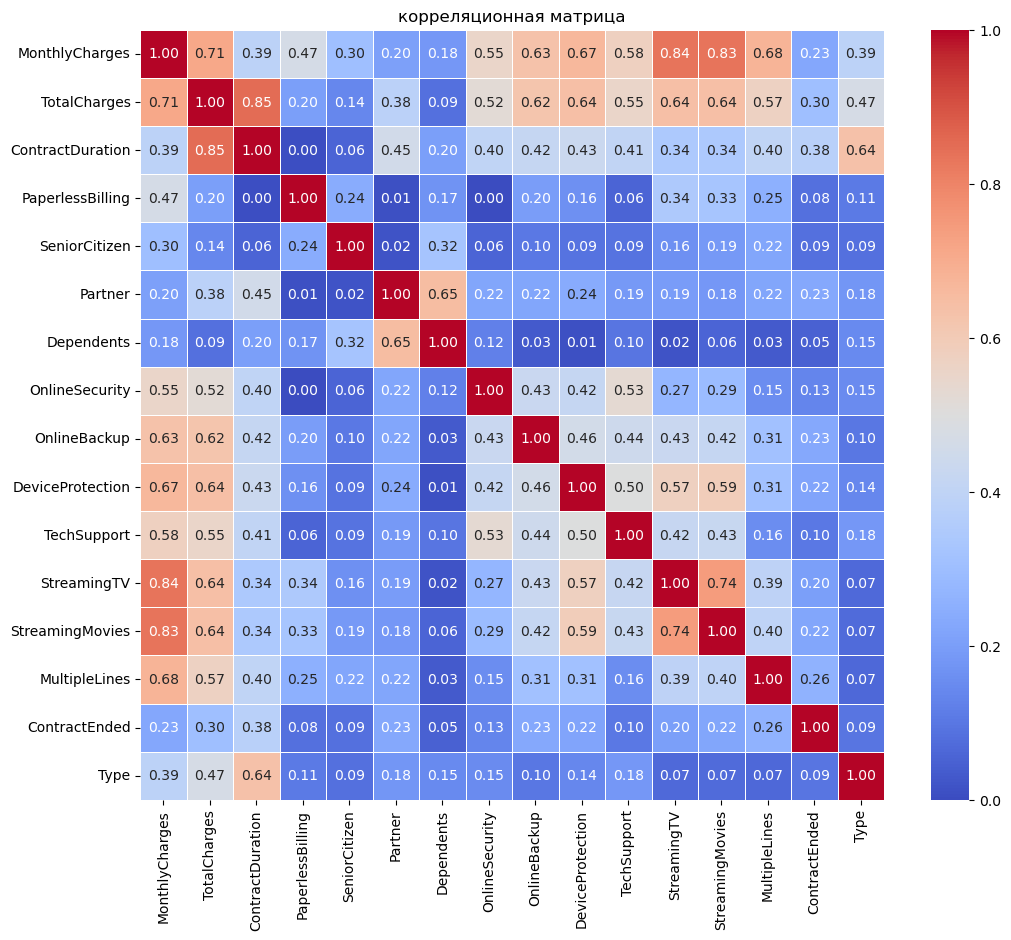

In [27]:
numeric_cols = ['MonthlyCharges', 'TotalCharges', 'ContractDuration']  
binary_cols = ['PaperlessBilling', 'SeniorCitizen', 'Partner', 'Dependents', 
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
               'StreamingTV', 'StreamingMovies', 'MultipleLines','ContractEnded','Type']  


cols_to_check = numeric_cols + binary_cols

phik_matrix = data_total[cols_to_check].phik_matrix()

plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('корреляционная матрица')
plt.show()

По тепловой карте видно что у признака dependents очень низкая корреляция с другими признаками, я бы удалил этот признак, также я сразу исключил из анализа столбцы связанные с датами, так как интерпретировать их корреляцию трудно.

In [28]:
data_total_2 = data_total.drop(['Dependents','BeginDate','EndDate'],axis = 1)

In [29]:
data_total_2

customerID            Type PaperlessBilling              PaymentMethod  \
0     7590-VHVEG  Month-to-month              Yes           Electronic check   
1     5575-GNVDE        One year               No               Mailed check   
2     3668-QPYBK  Month-to-month              Yes               Mailed check   
3     7795-CFOCW        One year               No  Bank transfer (automatic)   
4     9237-HQITU  Month-to-month              Yes           Electronic check   
...          ...             ...              ...                        ...   
7038  6840-RESVB        One year              Yes               Mailed check   
7039  2234-XADUH        One year              Yes    Credit card (automatic)   
7040  4801-JZAZL  Month-to-month              Yes           Electronic check   
7041  8361-LTMKD  Month-to-month              Yes               Mailed check   
7042  3186-AJIEK        Two year              Yes  Bank transfer (automatic)   

      MonthlyCharges  TotalCharges  gender  SeniorCitizen Partner  \
0              29.85         31.04  Female          False     Yes   
1              56.95       2071.84    Male          False      No   
2              53.85        226.17    Male          False      No   
3              42.30       1960.60    Male          False      No   
4              70.70        353.50  Female          False      No   
...              ...           ...     ...            ...     ...   
7038           84.80       2035.20    Male          False     Yes   
7039          103.20       7430.40  Female          False     Yes   
7040           29.60        325.60  Female          False     Yes   
7041           74.40        520.80    Male           True     Yes   
7042          105.65       7251.82    Male          False      No   

     InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0                DSL             No          Yes               No          No   
1                DSL            Yes           No              Yes          No   
2                DSL            Yes          Yes               No          No   
3                DSL            Yes           No              Yes         Yes   
4        Fiber optic             No           No               No          No   
...              ...            ...          ...              ...         ...   
7038             DSL            Yes           No              Yes         Yes   
7039     Fiber optic             No          Yes              Yes          No   
7040             DSL            Yes           No               No          No   
7041     Fiber optic             No           No               No          No   
7042     Fiber optic            Yes           No              Yes         Yes   

     StreamingTV StreamingMovies MultipleLines ContractEnded  ContractDuration  
0             No              No            No            no                 1  
1             No              No            No            no              1006  
2             No              No            No            no                93  
3             No              No            No            no              1341  
4             No              No            No            no               123  
...          ...             ...           ...           ...               ...  
7038         Yes             Yes           Yes            no               700  
7039         Yes             Yes           Yes            no              2161  
7040          No              No            No            no               307  
7041          No              No           Yes            no               185  
7042         Yes             Yes            No            no              1980  

[7032 rows x 19 columns]

## Подготовка данных
Напишем пайплайн для кодирования категориальных признаков и масштабирования численных и таким образом подготовим данные для моделирования.

In [30]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
X = data_total_2.drop(columns=['customerID','ContractEnded'])
y = data_total_2['ContractEnded'].map({'no': 0, 'yes': 1})


X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')
X['TotalCharges'].fillna(X['TotalCharges'].mean(), inplace=True)

numeric_cols = ['TotalCharges','ContractDuration','MonthlyCharges']
categorical_cols = ['PaymentMethod', 'gender', 'MultipleLines', 'PaperlessBilling',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Type','Partner','SeniorCitizen']


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_transformed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.25, random_state=210425)
X_transformed = preprocessor.fit_transform(X)
X_transformed

array([[-0.9881642 , -1.27924483, -1.16169394, ...,  1.        ,
         1.        ,  0.        ],
       [-0.02214434,  0.19231548, -0.26087792, ...,  0.        ,
         1.        ,  0.        ],
       [-0.89579873, -1.14453483, -0.36392329, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.84873319, -0.83118766, -1.17000405, ...,  1.        ,
         1.        ,  0.        ],
       [-0.75633458, -1.00982483,  0.31916782, ...,  1.        ,
         0.        ,  1.        ],
       [ 2.42981741,  1.61848438,  1.35793167, ...,  0.        ,
         1.        ,  0.        ]])

Пайплайн для обработки данных готов

## Обучение моделей машинного обучения
Обучим пару моделей подберём для них гиперпараметры и выберем лучшую ссылаясь на метрику roc auc, целевой переменной будет contractduration, ведь мы предсказываем ооток клиентов и стветсвенно продолжительность договоров

In [31]:
def evaluate_model(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    return np.mean(scores)


def objective_lr(trial):
    param_grid = {
        'C': trial.suggest_float('C', 1e-5, 1e2, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga'])
    }
    model = LogisticRegression(**param_grid, random_state=42)
    return evaluate_model(model, X_train, y_train)

study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=50)

best_lr_params = study_lr.best_params
auc_best_lr = study_lr.best_value
print("Логит-регрессия:")
print("  Параметры:", best_lr_params)
print("  ROC-AUC (CV):", auc_best_lr)


def objective_rf(trial):
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    model = RandomForestClassifier(**param_grid, random_state=42)
    return evaluate_model(model, X_train, y_train)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)

best_rf_params = study_rf.best_params
auc_best_rf = study_rf.best_value
print("\nСлучайный лес:")
print("  Параметры:", best_rf_params)
print("  ROC-AUC (CV):", auc_best_rf)


def objective_cat(trial):
    param_grid = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True)
    }
    
    model = CatBoostClassifier(**param_grid, random_state=42, verbose=0)
    return evaluate_model(model, X_train, y_train)

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=50)
best_cat_params = study_cat.best_params
auc_best_cat = study_cat.best_value
print("\nCatBoost:")
print("  Параметры:", best_cat_params)
print("  ROC-AUC (CV):", auc_best_cat)


model_scores = {
    'Logistic Regression': auc_best_lr,
    'Random Forest': auc_best_rf,
    'CatBoost': auc_best_cat
}
best_model_name = max(model_scores, key=model_scores.get)
print(f"\nЛучшая модель по ROC-AUC (CV): {best_model_name} — {model_scores[best_model_name]:.4f}")

if best_model_name == 'Logistic Regression':
    final_model = LogisticRegression(**best_lr_params, random_state=42, max_iter=1000)
elif best_model_name == 'Random Forest':
    final_model = RandomForestClassifier(**best_rf_params, random_state=42)
else:
    final_model = CatBoostClassifier(**best_cat_params, random_state=42, verbose=0)

final_model.fit(X_train, y_train)
y_pred_test_proba = final_model.predict_proba(X_test)[:, 1]
final_auc = roc_auc_score(y_test, y_pred_test_proba)
print(f"ROC-AUC на тестовой выборке: {final_auc:.4f}")
print(f"ROC-AUC на тестовой выборке: {final_auc:.4f}")

[I 2025-06-15 01:49:37,538] A new study created in memory with name: no-name-5ba25eca-88d9-4ce7-b1ae-2ab1c97708b9
[I 2025-06-15 01:49:37,673] Trial 0 finished with value: 0.7391528233161202 and parameters: {'C': 0.002689395671272851, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 0 with value: 0.7391528233161202.
[I 2025-06-15 01:49:37,712] Trial 1 finished with value: 0.7094566005474741 and parameters: {'C': 0.0003396961608302615, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7391528233161202.
[I 2025-06-15 01:49:37,765] Trial 2 finished with value: 0.7674408051651873 and parameters: {'C': 0.027088385460249165, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 2 with value: 0.7674408051651873.
[I 2025-06-15 01:49:38,437] Trial 3 finished with value: 0.7720542847827174 and parameters: {'C': 1.1273959763630164, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 3 with value: 0.7720542847827174.
[I 2025-06-15 01:49:38,570] Trial 4 finished with value: 0.71

Логит-регрессия:
  Параметры: {'C': 2.500422575797805, 'penalty': 'l2', 'solver': 'saga'}
  ROC-AUC (CV): 0.7721826847278312


[I 2025-06-15 01:49:53,490] Trial 0 finished with value: 0.8146512966241042 and parameters: {'n_estimators': 101, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8146512966241042.
[I 2025-06-15 01:49:54,705] Trial 1 finished with value: 0.8132665079273271 and parameters: {'n_estimators': 104, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8146512966241042.
[I 2025-06-15 01:49:58,452] Trial 2 finished with value: 0.8039263079096604 and parameters: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8146512966241042.
[I 2025-06-15 01:50:00,237] Trial 3 finished with value: 0.8194590134848289 and parameters: {'n_estimators': 112, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.8194590134848289.
[I 2025-06-15 01:50:02,277] Trial 4 finished with value: 0.8189709892590489 and parameters: {


Случайный лес:
  Параметры: {'n_estimators': 182, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 2}
  ROC-AUC (CV): 0.8212783004375132


[I 2025-06-15 01:51:47,366] Trial 0 finished with value: 0.9276634668399616 and parameters: {'iterations': 348, 'depth': 5, 'learning_rate': 0.10077650692497152, 'l2_leaf_reg': 0.0486067951315755}. Best is trial 0 with value: 0.9276634668399616.
[I 2025-06-15 01:51:51,454] Trial 1 finished with value: 0.8526278533807444 and parameters: {'iterations': 146, 'depth': 8, 'learning_rate': 0.27489939014845993, 'l2_leaf_reg': 0.020307448040768537}. Best is trial 0 with value: 0.9276634668399616.
[I 2025-06-15 01:51:53,352] Trial 2 finished with value: 0.8759114659730003 and parameters: {'iterations': 168, 'depth': 4, 'learning_rate': 0.06850244967396692, 'l2_leaf_reg': 0.008698139420241623}. Best is trial 0 with value: 0.9276634668399616.
[I 2025-06-15 01:51:58,399] Trial 3 finished with value: 0.9254053911999012 and parameters: {'iterations': 357, 'depth': 6, 'learning_rate': 0.1894902431999122, 'l2_leaf_reg': 0.13574479953079333}. Best is trial 0 with value: 0.9276634668399616.
[I 2025-06-1


CatBoost:
  Параметры: {'iterations': 357, 'depth': 4, 'learning_rate': 0.22805649317279778, 'l2_leaf_reg': 0.0907935004961145}
  ROC-AUC (CV): 0.9460555815931875

Лучшая модель по ROC-AUC (CV): CatBoost — 0.9461
ROC-AUC на тестовой выборке: 0.9631
ROC-AUC на тестовой выборке: 0.9631


## Анализ лучшей модели
Лучшей моделью оказалась catboost, чтобы интерпретировать работу модели выведем визуализацию важности признаков и матрицу ошибок

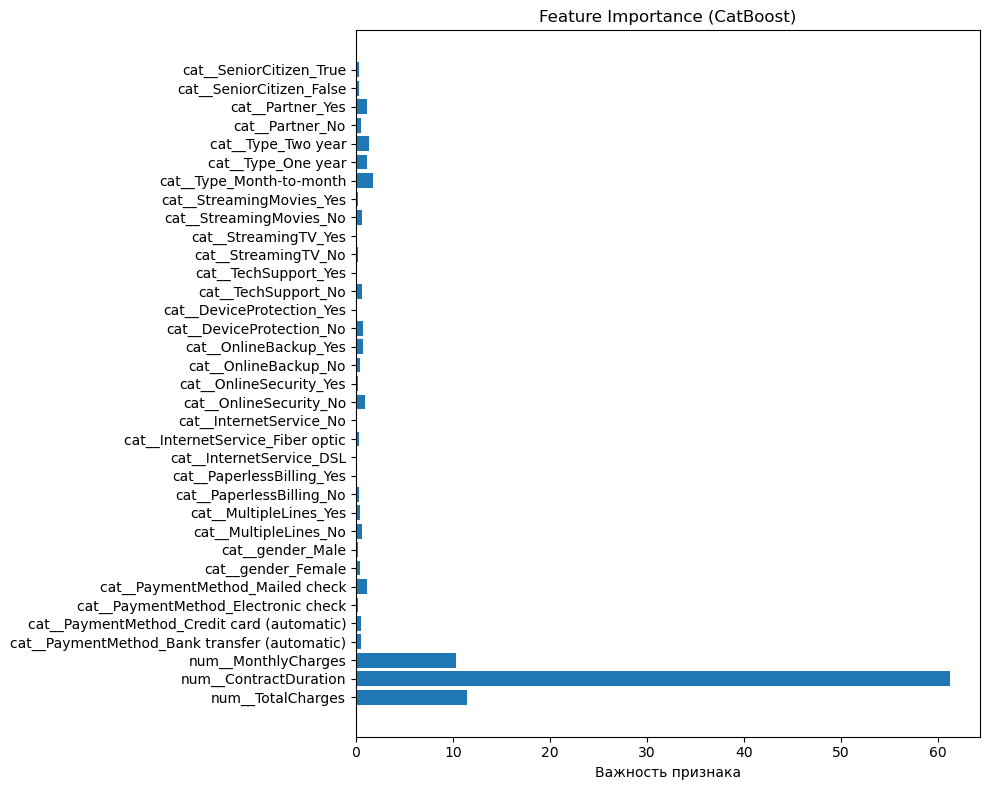

In [32]:
feature_names = preprocessor.get_feature_names_out()
importances = final_model.get_feature_importance()
plt.figure(figsize=(10, 8))
plt.barh(feature_names, importances)
plt.xlabel("Важность признака")
plt.title("Feature Importance (CatBoost)")
plt.tight_layout()
plt.show()

Самым важным признаком с большим отрывом оказался добавленный признак ContractDuration и следующими по важности оказались признаки связанные с оплатой то есть MonthlyCharges и TotalCharges, остальные признаки оказались не на столько весомыми

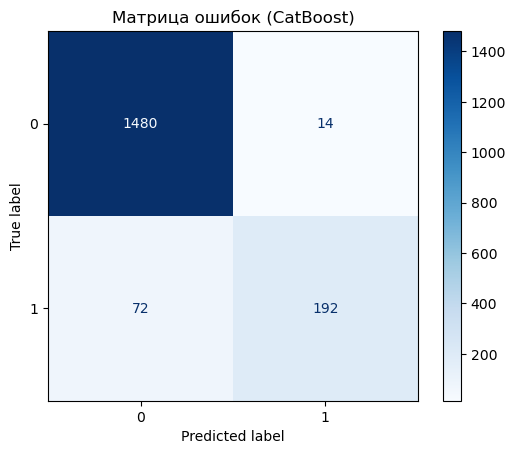

In [33]:
y_pred_test = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Матрица ошибок (CatBoost)")
plt.show()

По матрице ошибок можно понять что модель хорошо определяет тех, кто остаётся (высокое число TN, низкое FP) и не так хорошо определяет тех кто собирается уйти

## Выводы

В данном проекте требовалось обучить модель для предсказания оттока клиентов, по скольку целевой переменной отвечающей за это не было я решил добавить целевой признак который соответсвовал тому кончился ли договор с клиентом или нет.

Для начала я загрузил данные и поменял типы столбцов на корректные, ведь все столбцы  в том числе и числовые и даты относились к типу object. Еще при обьеденении таблиц образовалось множество пропусков в столбцах с услугами, которые я заменил на no что означает что клиент не пользовался данной услугой.

Вторым шагом я провёл исследовательский аналаз, визуализировав данные при помощи YDATA и получилось вывести следующие закономерности:
В столбце Type в основном клиенты оплачивают счета помесячно

В столбце PaperlessBilling в основном значение Yes(True)

В столбце PaymentMethod лидирует Electronic check

В столбце MonthlyCharges бОльшая часть значений расположена в пределах 18-20 и есть несколько выбросов в районе 117-119

В столбце TotalCharges бОльшая часть значений расположена в пределах от 0 до 2000, и есть несколько выбросов около 9000

В столбце Gender мужчин и женщин примерно поровну 

В столбце SeniorCitizen бОльшая часть записей это 0(False) то есть пинсионеров меньшинство 

В столбце Partner True и False распределено примерно поровну

В столбце Dependents у большинства клиентов нет детей 

В столбце InternetService у большинства клиентов Fiber optic

В столбце OnlineSecurity у большинства клиентов нет защиты 

В столбце OnlineBackup у большинства клиентов нет бекапов

В столбце DeviceProtection у большинства клиентов нет защиты 

В столбце TechSupport у большинства клиентов не выделена линия поддержки 

В столбце StreamingTV примерно по ровну клиентов с тв и без 

В столбце StreamingMovies примерно по ровну клиентов со стримингом и без 

В столбце MultipleLines примерно по ровну клиентов с подключением к разным линиям и без

Третьим шагом я обьеденил все таблицы в одну и при помощи хитмапы корреляций признаков выявил какие признаки меньше всего влияют на остальные и исключил их, таким признаком оказался 'Dependents'

Четвёртым шагом я написал пайплайн чтобы закодировать данные перед моделированием при помощи ohe и standartscaler для вещественных и числовых признаков.

Пятым шагом я обучил две модели а именно randomforest и logistic reggresion, catboost,подобрал для них гиперпараметры через optuna и выбрал среди моделей с лучшими параметрами ту у которой выше метрика roc-auc, выше она оказалась у catboost и оказалась равной 0.9558

Лучшие параметры для лучшей модели - {'iterations': 365, 'depth': 4, 'learning_rate': 0.15995122858187838, 'l2_leaf_reg': 0.01674796738306154} подобранные с помощью optuna 
Признаки на которых обучалась модель - 'Type', 'PaperlessBilling', 'PaymentMethod','MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'ContractDuration'

Вот какие рекомендации я бы хотел дать заказчику:

- Поскольку модель показала высокую метрику ROC-AUC (0.9945), её можно использовать для предсказания вероятного оттока клиентов.
- Для клиентов с высокой вероятностью оттока можно:
  - предлагать специальные условия (скидки, бонусы);
  - делать персонализированные предложения;
  - усиливать техподдержку и улучшать сервис.
- Регулярно обновлять модель новыми данными для сохранения точности.
- Обратить внимание на признаки, которые чаще всего встречаются у уходящих клиентов, например: высокая плата, отсутствие технической поддержки или дополнительных услуг.
